In [92]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [93]:
path = 'archive/train.csv'

In [94]:
df = pd.read_csv(path)

In [95]:
df

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,ID58588,0.355089,0.13,0.644231,C8,8794,2,A,M3,Petrol,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0
58588,ID58589,1.199642,0.02,0.519231,C14,7788,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58589,ID58590,1.162273,0.05,0.451923,C5,34738,1,A,M1,CNG,...,No,No,No,Yes,No,No,No,Yes,0,0
58590,ID58591,1.236307,0.14,0.557692,C8,8794,1,B2,M6,Petrol,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0


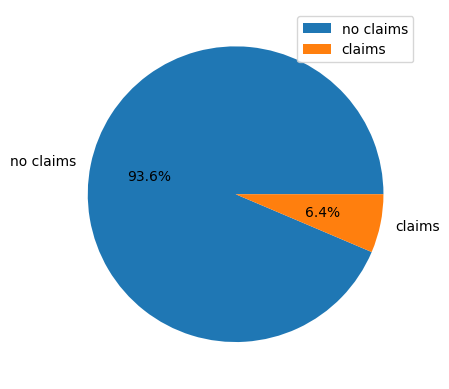

In [96]:
plt.pie(df["is_claim"].value_counts(), labels=["no claims", "claims"], autopct='%1.1f%%')
plt.legend(labels=["no claims", "claims"], loc="upper right")

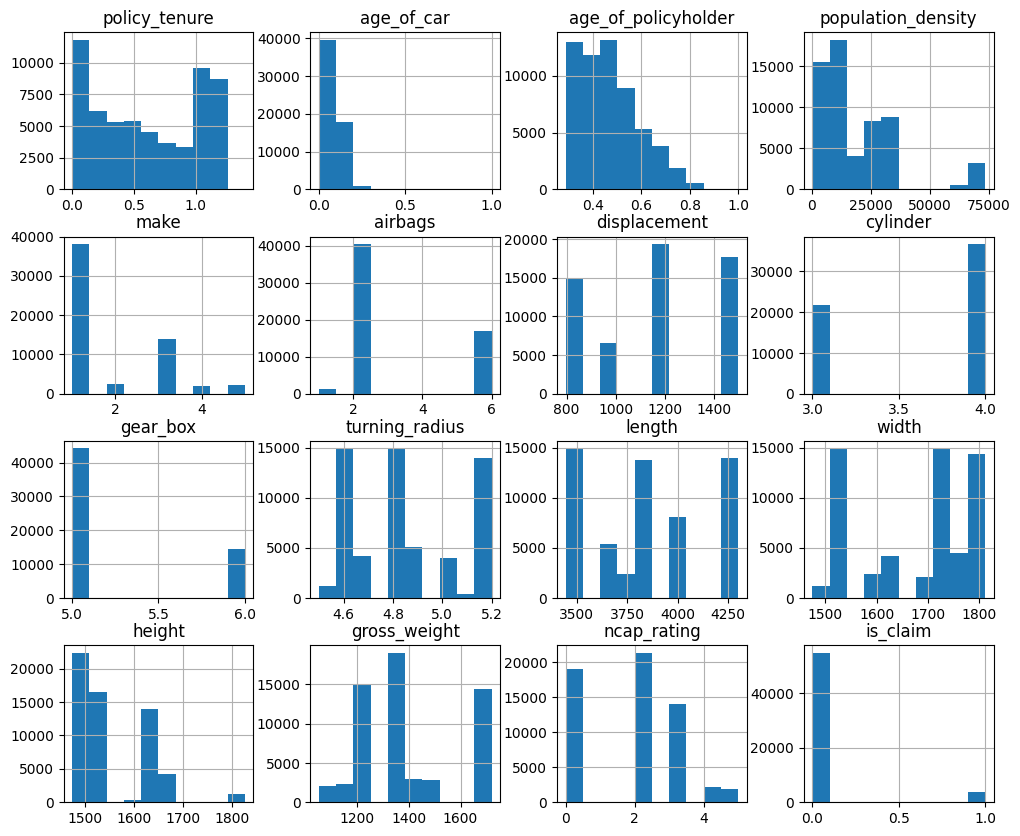

In [97]:
df.hist(figsize=(12, 10))
plt.show()

<Axes: xlabel='area_cluster'>

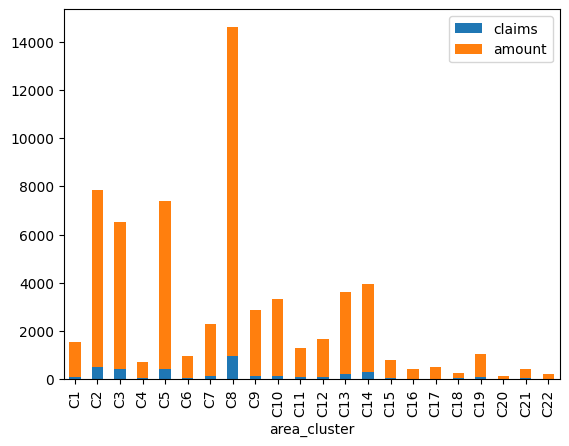

In [98]:
order = [f'C{i}' for i in range(1, 23)]
result = df.groupby('area_cluster').agg({'is_claim': 'sum', 'area_cluster' : 'size'})
result.columns = ['claims', 'amount']
result = result.reindex(order)

result.plot(kind='bar', stacked=True)

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Data Prep

In [100]:
#list(df.columns)

In [101]:
one_hot_var = ['make','area_cluster','segment','fuel_type','is_esc',
               'model',                   
'max_torque',            
'max_power',               
'engine_type',             
'airbags',                  
'rear_brakes_type',        
'displacement',             
'cylinder',                
'transmission_type',       
'gear_box',                 
'steering_type',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger','is_brake_assist','is_power_door_locks','is_central_locking','is_power_steering','is_driver_seat_height_adjustable','is_day_night_rear_view_mirror','is_ecw','is_speed_alert','ncap_rating']

In [102]:
df = df.drop(columns=['policy_id'])

In [103]:
df = pd.get_dummies(data = df,
                         prefix = one_hot_var,
                         columns = one_hot_var)

In [104]:
df.head(3)

,policy_tenure,age_of_car,age_of_policyholder,population_density,turning_radius,length,width,height,gross_weight,is_claim,...,is_day_night_rear_view_mirror_Yes,is_ecw_No,is_ecw_Yes,is_speed_alert_No,is_speed_alert_Yes,ncap_rating_0,ncap_rating_2,ncap_rating_3,ncap_rating_4,ncap_rating_5
0,0.515874,0.05,0.644231,4990,4.6,3445,1515,1475,1185,0,...,False,True,False,False,True,True,False,False,False,False
1,0.672619,0.02,0.375000,27003,4.6,3445,1515,1475,1185,0,...,False,True,False,False,True,True,False,False,False,False
2,0.841110,0.02,0.384615,4076,4.6,3445,1515,1475,1185,0,...,False,True,False,False,True,True,False,False,False,False


In [105]:
features = [x for x in df.columns if x not in 'is_claim']

In [106]:
print(len(features))

147


In [107]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['is_claim'], train_size = 0.8)

In [108]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 46873
validation samples: 11719
target proportion: 0.0633


## Decision Tree

In [109]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 10).fit(X_train,y_train)

In [110]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9376
Metrics validation:
	Accuracy score: 0.9329


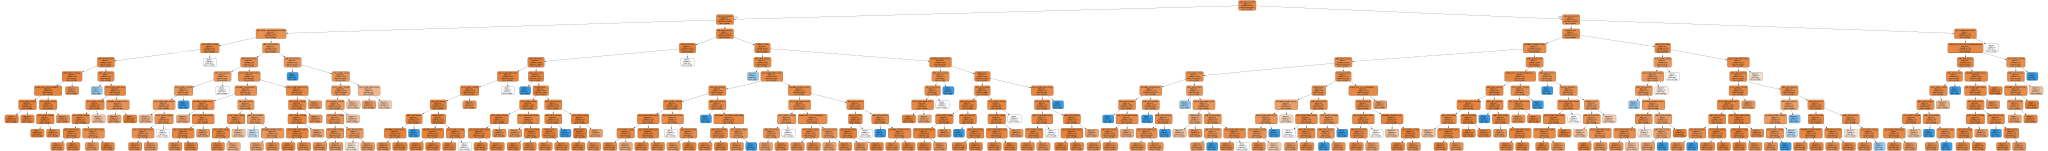

In [111]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(decision_tree_model, out_file=None, 
                           feature_names=features,  
                           class_names=['no claim', 'claim'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

graph = graphviz.Source(dot_data)  
graph.render(format='png')
graph


## Random Forest

In [112]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [113]:
random_forest_10 = RandomForestClassifier(n_estimators=10).fit(X_train,y_train)

In [114]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_10.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(random_forest_10.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9858
Metrics validation:
	Accuracy score: 0.9252


In [115]:
random_forest_50 = RandomForestClassifier(n_estimators=50).fit(X_train,y_train)

In [116]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_50.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(random_forest_50.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9984
Metrics validation:
	Accuracy score: 0.9272


## Classifiers

In [117]:
model_bag = BaggingClassifier(max_samples=0.5, max_features=0.5).fit(X_train, y_train)

In [118]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model_bag.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(model_bag.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9401
Metrics validation:
	Accuracy score: 0.9330


In [119]:
model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                               n_estimators=20).fit(X_train, y_train)

/Users/abdul/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [120]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(model_ada.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9620
Metrics validation:
	Accuracy score: 0.9139
